### Import Libraries

In [85]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
warnings.filterwarnings('ignore', message='foo bar')
import pandas as pd

from numpy import mean
from numpy import std

%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Import Datset

In [2]:
energy = pd.read_csv("electricity.csv", index_col=False)
print('Overview del dataset:')
energy.head() 

Overview del dataset:


,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


**First EDA technique**

In [3]:
print('-------Información de New South Whales:')
print('\n+++Price:')
print ("-Mínimo valor de nswprice %f" % energy['nswprice'].min()) 
#1r quartil, mediana y 3r quartil
print(energy.nswprice.quantile([0.25,0.5,0.75]) )
print ("+Máximo valor de nswprice %f\n\n" % energy['nswprice'].max()) 
print('+++Demand:')
print ("-Mínimo valor de nswdemand %f" % energy['nswdemand'].min()) 
#1r quartil, mediana y 3r quartil
print(energy.nswdemand.quantile([0.25,0.5,0.75]) )
print ("+Máximo valor de nswdemand %f\n\n" % energy['nswdemand'].max()) 

print('-------Información de Victoria:')
print('\n+++Price:')
print ("-Mínimo valor de vicprice %f" % energy['vicprice'].min()) 
#1r quartil, mediana y 3r quartil
print(energy.vicprice.quantile([0.25,0.5,0.75]) )
print ("+Máximo valor de vicprice %f\n\n" % energy['vicprice'].max()) 
print('+++Demand:')
print ("-Mínimo valor de vicdemand %f" % energy['vicdemand'].min()) 
#1r quartil, mediana y 3r quartil
print(energy.vicdemand.quantile([0.25,0.5,0.75]) )
print ("+Máximo valor de vicdemand %f\n\n" % energy['vicdemand'].max()) 

-------Información de New South Whales:

+++Price:
-Mínimo valor de nswprice 0.000000
0.25    0.035067
0.50    0.048607
0.75    0.074336
Name: nswprice, dtype: float64
+Máximo valor de nswprice 1.000000


+++Demand:
-Mínimo valor de nswdemand 0.000000
0.25    0.309283
0.50    0.443767
0.75    0.536150
Name: nswdemand, dtype: float64
+Máximo valor de nswdemand 1.000000


-------Información de Victoria:

+++Price:
-Mínimo valor de vicprice 0.000000
0.25    0.002275
0.50    0.003467
0.75    0.003467
Name: vicprice, dtype: float64
+Máximo valor de vicprice 1.000000


+++Demand:
-Mínimo valor de vicdemand 0.000000
0.25    0.372346
0.50    0.422915
0.75    0.469705
Name: vicdemand, dtype: float64
+Máximo valor de vicdemand 1.000000




**Second EDA technique**

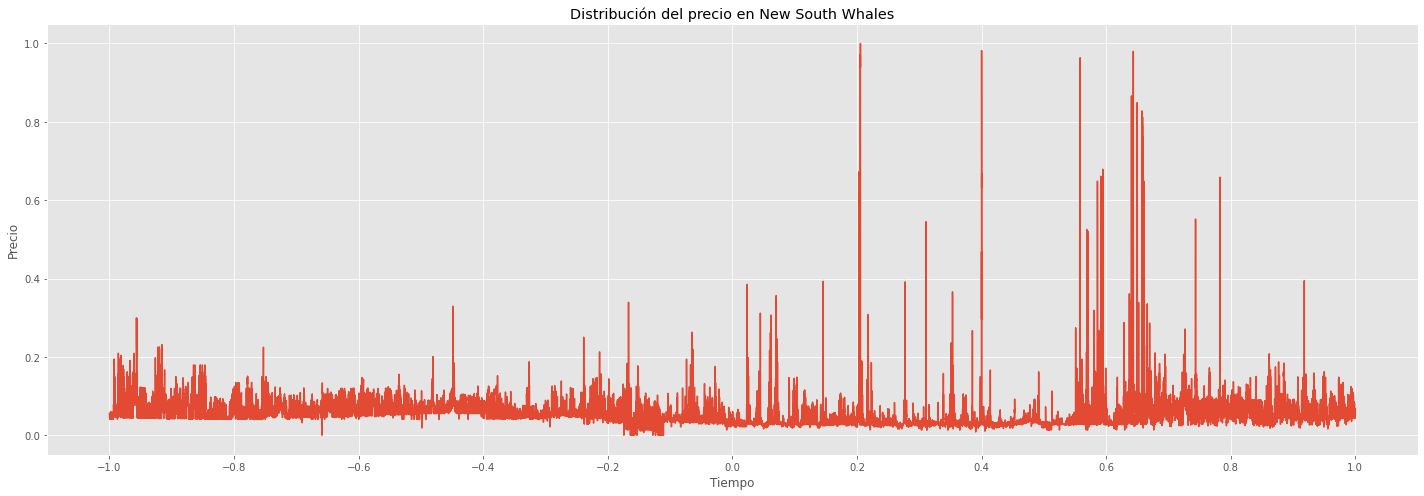

In [4]:
plt.style.use('ggplot')
x = np.linspace(-1, 1, 45371) #Para poder dar una representación de como avanza el tiempo. 
y = energy['nswprice']

plt.figure(figsize=(20,7))
plt.title('Distribución del precio en New South Whales')
plt.ylabel('Precio')
plt.xlabel('Tiempo')
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.20))
plt.tight_layout()
plt.plot(x, y)
plt.show()

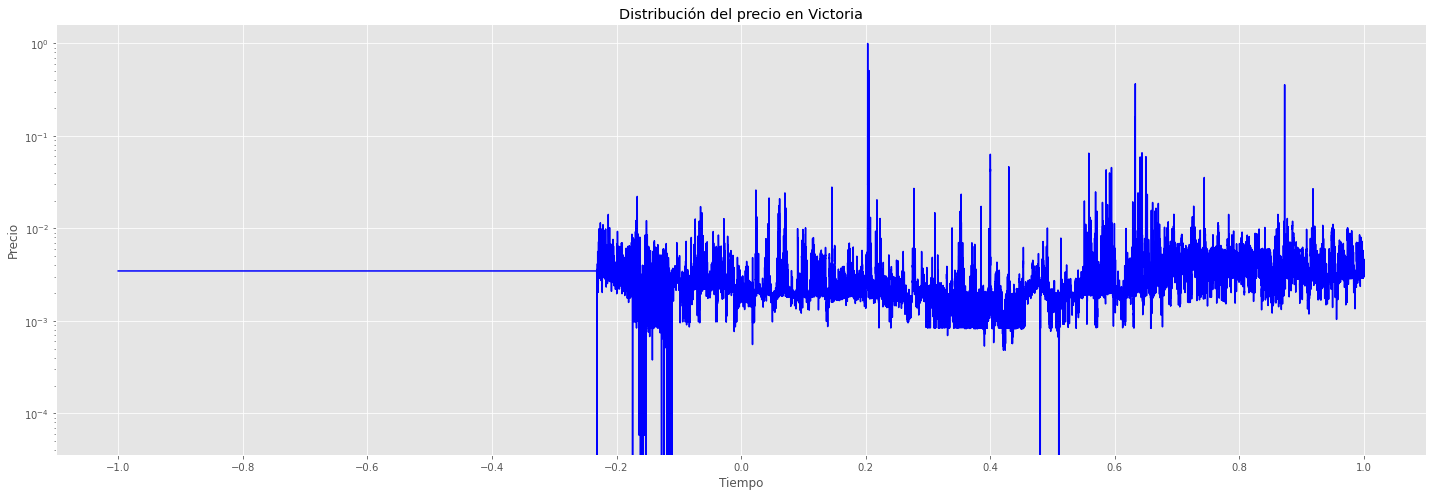

In [5]:
plt.style.use('ggplot')
x = np.linspace(-1, 1, 45371) #Para poder dar una representación de como avanza el tiempo. 
y = energy['vicprice']

plt.figure(figsize=(20,7))
plt.title('Distribución del precio en Victoria')
plt.ylabel('Precio')
plt.xlabel('Tiempo')
ax=plt.gca()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.20))
plt.tight_layout()
plt.yscale('log')
plt.plot(x, y, color = 'blue')
plt.show()

**First cleaning technique (Duplicates)**

In [6]:
#Filas iniciales
print('Filas: %d' %( energy.shape[0] )) 
dup = energy.duplicated()
energy.drop_duplicates(inplace=True)
print('Filas después de eliminar duplicados: %d' %( energy.shape[0] ))

Filas: 45371
Filas después de eliminar duplicados: 45312


**Second cleaning technique (Outliers)**

In [7]:
columnsToCheck= ['nswdemand','vicdemand','nswprice','nswprice']

#Vamos a revisar cada una de estas columnas por outliers.
for act_col in columnsToCheck:
    data_mean, data_std = mean(energy[act_col]), std(energy[act_col])
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in energy[act_col] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    energy = energy[~energy[act_col].isin(outliers)]
    print('Number of rows after outlier removal: %d' %( energy.shape[0] )) 

Identified outliers: 25
Number of rows after outlier removal: 45287
Identified outliers: 212
Number of rows after outlier removal: 45075
Identified outliers: 373
Number of rows after outlier removal: 44702
Identified outliers: 472
Number of rows after outlier removal: 44230


**ANOVA F via f_classif() to delete unnecessary columms, that do not contribute well to the models.**

In [8]:
#Dividimos las columnas del target.
X = energy.iloc[:,0:8]# Columnas, menos target
Y = energy["class"]# Target Column, tiene a 'class'

#Define Feature Selection
values= [7,6,5]

for pos_val in values:
    k=pos_val
    print("\nCon k =", pos_val)
    bestFeatures = SelectKBest(score_func=f_classif, k=k)
    #fit = bestFeatures.fit(X,Y.values.ravel()) #values.ravel gives the values in an array and converts that array shape to (n, )
    X_selected = bestFeatures.fit_transform(X, Y)
    print("Shape y columnas a usar:", X_selected.shape)
    column_names= ["day","period","nswprice","nswdemand","vicprice","vicdemand","transfer"]
    top_features = sorted(zip(column_names, bestFeatures.scores_), key=lambda x: x[1], reverse=True)
    print(top_features[:k]) #Same as k from SelectKBest



Con k = 7
Shape y columnas a usar: (44230, 7)
[('nswdemand', 13841.718984444013), ('vicprice', 4792.334320911628), ('transfer', 2148.320718628895), ('nswprice', 1005.9914536886434), ('vicdemand', 684.613678677144), ('period', 99.465870626337), ('day', 4.619990895275652)]

Con k = 6
Shape y columnas a usar: (44230, 6)
[('nswdemand', 13841.718984444013), ('vicprice', 4792.334320911628), ('transfer', 2148.320718628895), ('nswprice', 1005.9914536886434), ('vicdemand', 684.613678677144), ('period', 99.465870626337)]

Con k = 5
Shape y columnas a usar: (44230, 5)
[('nswdemand', 13841.718984444013), ('vicprice', 4792.334320911628), ('transfer', 2148.320718628895), ('nswprice', 1005.9914536886434), ('vicdemand', 684.613678677144)]


**Split Data into training set and testing set**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_selected,
                                                    Y,
                                                    test_size = 0.3,
                                                    stratify = Y,
                                                    random_state = 39564)

### XGBoost Classification

**Cross Validation Score**

In [57]:
xgb = XGBClassifier()

# define the cross-validation procedure
cvA = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

# evaluate model
#En vez de usar X, usamos X_selected, en el que ya aplicamos SelectKBest
scoresA = cross_val_score(xgb, X_selected, Y,  scoring ='accuracy', cv = cvA)

# report performance
print('Accuracy of model A (XGBoost): %.3f (%.3f)' % (mean(scoresA), std(scoresA)))
print(scoresA)

[09:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[09:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model A (XGBoost): 0.802 (0.005)
[0.80171829 0.80217047 0.

**Best Score by Xgboost**

In [76]:
scoresA.max()

0.8125706534026679

**Accuracy Scores by Cross Validation Values (XGBoost)**

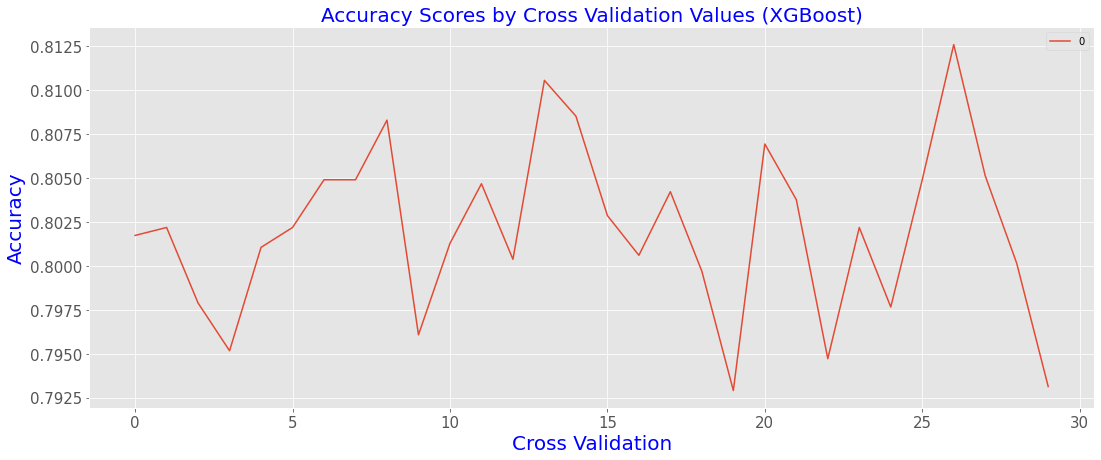

In [71]:
pd.DataFrame(scoresA).plot(figsize = (18, 7))
plt.title("Accuracy Scores by Cross Validation Values (XGBoost)", size = 20, color = "blue")
plt.xlabel("Cross Validation", size = 20, color = "blue")
plt.ylabel("Accuracy", size = 20, color = "blue")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

**Grid Search CV XGBClassification**

In [80]:
params = {'n_estimators': [10,300,1000],
          'max_depth': [1,6,10],
          'eta': [0.0001, 0.01, 0.5, 1.0]}

xgb = XGBClassifier()

cv_a = GridSearchCV(xgb, params, cv = 5)

cv_a.fit(X_train, y_train)

cv_a.best_params_

[10:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:24:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:32:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'eta': 0.01, 'max_depth': 10, 'n_estimators': 1000}

**XGB Classification with Best Hyperparameters**

In [81]:
xgb = XGBClassifier(eta = 0.01, max_depth = 10, n_estimators = 1000)

xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)
pd.DataFrame({"Actual": y_test,
              "Predicted": pred_xgb}).sample(10)


[10:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Actual,Predicted
19525,UP,UP
21309,DOWN,DOWN
10353,DOWN,DOWN
2069,DOWN,UP
15637,DOWN,DOWN
20444,UP,UP
37447,DOWN,DOWN
6856,DOWN,DOWN
6005,DOWN,DOWN
31046,DOWN,DOWN


**Accuracy by Tuned Hyperparameters (XGBoost)**

In [83]:
accuracy_score(y_test, pred_xgb)

0.8073705629663125

**Replace object type by int to made densdity plot**

In [102]:
comparison = pd.DataFrame({"Actual": y_test,
                           "Predicted": pred_xgb})
comparison["Actual"] = comparison["Actual"].replace({"DOWN": 1, "UP": 0})
comparison["Predicted"] = comparison["Predicted"].replace({"DOWN": 1, "UP": 0})

**Density Plot of Class {0 = UP and 1 = DOWN} by XGBoost**

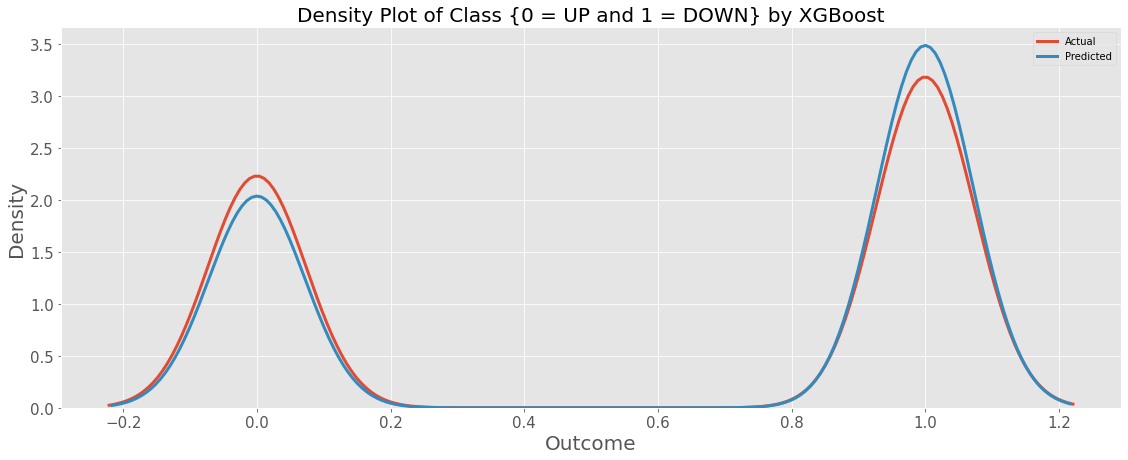

In [108]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = comparison, x = "Actual", label = "Actual", linewidth = 3)
sns.kdeplot(data = comparison, x = "Predicted", label = "Predicted", linewidth = 3)
plt.title("Density Plot of Class {0 = UP and 1 = DOWN} by XGBoost", size = 20)
plt.xlabel("Outcome", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend()
plt.show()

### Extra Trees Classification

**Cross Validation Score**

In [72]:
xt = ExtraTreesClassifier()

# define the cross-validation procedure
cvB = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

# evaluate model
#En vez de usar X, usamos X_selected, en el que ya aplicamos SelectKBest
scoresB = cross_val_score(xt, X_selected, Y,  scoring ='accuracy', cv = cvB)

# report performance
print('Accuracy of model B (Extra Trees): %.3f (%.3f)' % (mean(scoresB), std(scoresB)))
print(scoresB)

Accuracy of model B (Extra Trees): 0.807 (0.006)
[0.81166629 0.80420529 0.81370111 0.80443138 0.81483156 0.80126611
 0.81211847 0.81279674 0.79063984 0.80669229 0.80352702 0.80533574
 0.81189238 0.80737056 0.79968347 0.80375311 0.79764865 0.81573593
 0.80737056 0.80759665 0.80262265 0.81370111 0.81211847 0.80669229
 0.80352702 0.80058784 0.80578793 0.79945738 0.81867511 0.81166629]


**Best Score by Extra Trees**

In [75]:
max(scoresB)

0.8186751073931721

**Accuracy Scores by Cross Validation Values (Extra Trees)**

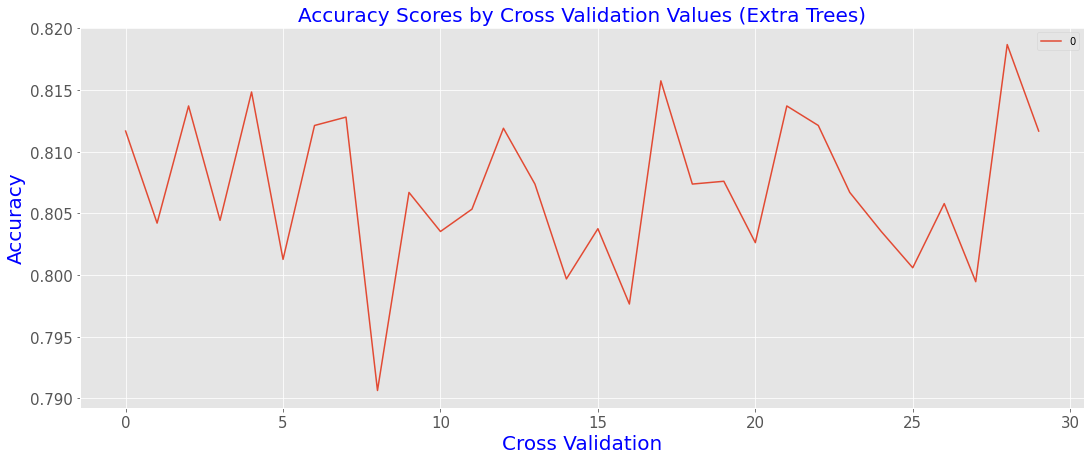

In [73]:
pd.DataFrame(scoresB).plot(figsize = (18, 7))
plt.title("Accuracy Scores by Cross Validation Values (Extra Trees)", size = 20, color = "blue")
plt.xlabel("Cross Validation", size = 20, color = "blue")
plt.ylabel("Accuracy", size = 20, color = "blue")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

**Grid Search CV Extra Trees**

In [110]:
params = {"min_samples_leaf": [0.1, 0.2, 0.3],
          "n_estimators": [50, 100, 150],
          "max_depth": [3, 4, 5]}

xt = ExtraTreesClassifier()

cv = GridSearchCV(xt, params, cv = 5)

cv.fit(X_train, y_train)

cv.best_params_

{'max_depth': 3, 'min_samples_leaf': 0.1, 'n_estimators': 50}

**Extra Trees Classification with Best Hyperparameters**

In [117]:
xt = ExtraTreesClassifier(max_depth = 3, min_samples_leaf = 0.1, n_estimators = 50)

xt.fit(X_train, y_train)

pred_xt = xt.predict(X_test)
pd.DataFrame({"Actual": y_test,
              "Predicted": pred_xt}).sample(10)

,Actual,Predicted
40375,UP,DOWN
6434,DOWN,DOWN
2513,DOWN,DOWN
22631,UP,DOWN
24486,UP,DOWN
8880,UP,UP
9126,DOWN,DOWN
6738,DOWN,DOWN
485,DOWN,DOWN
13843,UP,UP


**Accuracy by Tuned Hyperparameters**

In [118]:
accuracy_score(y_test, pred_xt)

0.7048006631999397

**Replace object type by int to made densdity plot**

In [113]:
comparison_xt = pd.DataFrame({"Actual": y_test,
                              "Predicted": pred_xgb})
comparison_xt["Actual"] = comparison_xt["Actual"].replace({"DOWN": 1, "UP": 0})
comparison_xt["Predicted"] = comparison_xt["Predicted"].replace({"DOWN": 1, "UP": 0})

**Density Plot of Class {0 = UP and 1 = DOWN} by Extra Trees**

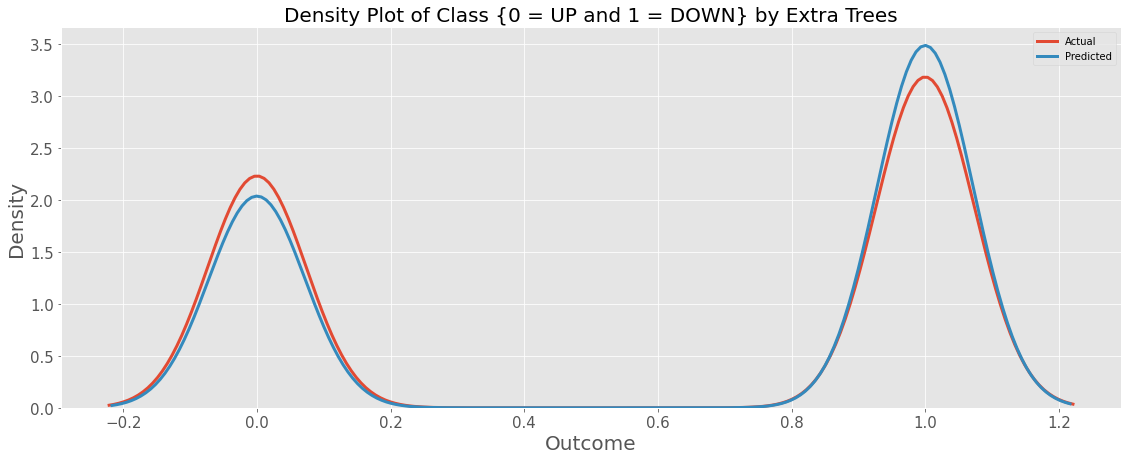

In [115]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = comparison_xt, x = "Actual", label = "Actual", linewidth = 3)
sns.kdeplot(data = comparison_xt, x = "Predicted", label = "Predicted", linewidth = 3)
plt.title("Density Plot of Class {0 = UP and 1 = DOWN} by Extra Trees", size = 20)
plt.xlabel("Outcome", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend()
plt.show()

### Performance Table

In [120]:
performance = pd.DataFrame({"Models": ["XGBoost", "ExtraTrees"],
                            "Cross Validation": [0.8125706534026679, 0.8186751073931721],
                            "Grid Search CV": [0.8073705629663125, 0.7048006631999397]})
performance.set_index("Models")

,Cross Validation,Grid Search CV
Models,,
XGBoost,0.812571,0.807371
ExtraTrees,0.818675,0.704801
